# Quantum state learning strawberry fields

In [33]:
from qutip import *
import strawberryfields as sf
from strawberryfields.ops import *
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors, colorbar, cm
import time
from tqdm.notebook import tqdm

In [9]:
def plot_wigner(rho, fig=None, ax=None):
    """
    Plot the Wigner function and the Fock state distribution given a density matrix for
    a harmonic oscillator mode.
    """
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4,4))

    if isket(rho):  # ket状態を密度関数にする（必要かわからん）
        rho = ket2dm(rho)
    
    scale = np.sqrt(2)
    xvec = np.linspace(-5*scale,5*scale,100)

    W = wigner(rho, xvec, xvec)
    wlim = abs(W).max()

    ax.contourf(xvec/scale, xvec/scale, W, 60, norm=mpl.colors.Normalize(-wlim,wlim), cmap=mpl.cm.get_cmap('RdBu'))
    ax.set_xlabel('q', fontsize=16)
    ax.set_ylabel('p', fontsize=16)
    ax.axis("off")
    #ax.set_title()
    fig.tight_layout
    
    return fig, ax

まずは1-moodeのQNNを構成する

In [20]:
def variational_quantum_circuit(params):
    #s = time.perf_counter()
    # Gate layer: D-R-S-R-K
    def layer(i, q):
        Rgate(params[i*7+0])                | q
        Sgate(params[i*7+1], params[i*7+2]) | q
        Rgate(params[i*7+3])                | q
        Dgate(params[i*7+4], params[i*7+5]) | q
        Kgate(params[i*7+6])                | q
        return q
    
    # Start SF program
    prog = sf.Program(1)

    # construct the circuit
    with prog.context as q:
        Vacuum() | q
        for k in range(depth):
            q = layer(k, q)
    
    eng = sf.Engine("fock", backend_options={"cutoff_dim": dim})
    state = eng.run(prog).state
    ket = state.ket()

    #e = time.perf_counter()  
    #print('time',e-s)
    return ket#, e-s

cost関数を定義。ここでは以下の関数とする。

$C(\theta) = |1-\langle \Psi_{t}|U(\theta)|0\rangle|$

In [21]:
def cost(target_state, ket): # target_stateとketはnumpy.ndarrayを想定している
    # fidelityを計算
    inner_product = np.conjugate(target_state.T) @ ket
    return abs(1 - inner_product)

Loss関数の勾配を計算する関数を定義

In [22]:
def get_cost_gradient(params):
    eps = 0.001
    grad_vector = np.zeros_like(params)
    tmp_params = np.copy(params)
    for i in range(len(params)):
        tmp_params[i] += eps
        state_plus = variational_quantum_circuit(tmp_params)
        cost_plus = cost(target_state, state_plus)
        #print("cost plus", cost_plus)
        tmp_params[i] -= 2*eps
        state_minus = variational_quantum_circuit(tmp_params)
        cost_minus = cost(target_state, state_minus)
        #print("cost minus", cost_minus)
        #print((cost_plus-cost_minus)/2/eps)
        grad_vector[i] = (cost_plus-cost_minus)/2/eps
        tmp_params[i] = params[i]
    return grad_vector

In [23]:
def Adam(params, rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-07, steps=100):
    m_0 = 0
    v_0 = 0
    tmp_params = np.copy(params)
    params_history = []
    params_history.append(np.copy(tmp_params))
    for i in tqdm(range(steps)):
        grad = get_cost_gradient(tmp_params)
        m_0 = beta1 * m_0 + (1 - beta1) * grad
        v_0 = beta2 * v_0 + (1 - beta2) * grad * grad
        m = m_0 / (1 - beta1)
        v = v_0 / (1 - beta2)
        tmp_params -= rate * m / np.sqrt(v + epsilon)
        params_history.append(np.copy(tmp_params))
        
    return tmp_params, params_history

In [24]:
def GD(params, rate=0.1, steps=100):
    tmp_params = np.copy(params)
    params_history = []
    params_history.append(np.copy(tmp_params))
    for i in tqdm(range(steps)):
        grad = get_cost_gradient(tmp_params)
        tmp_params -= rate * grad
        params_history.append(np.copy(tmp_params))
        
    return tmp_params, params_history

ターゲットとして|1>を使う

[0. 1. 0. 0. 0. 0.]


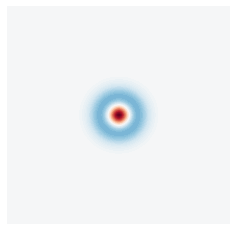

In [31]:
dim = 6
target_state = np.zeros(dim)
target_state[1] = 1
target_state = target_state / (np.conjugate(target_state.T) @ target_state) # 規格化
plot_wigner(Qobj(target_state))
print(target_state)

最適化を行う

  0%|          | 0/1000 [00:00<?, ?it/s]

time 210.15599536895752 s


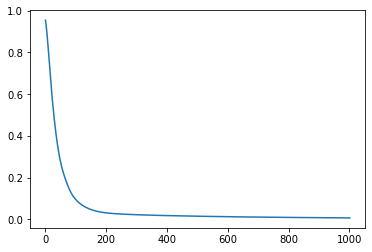

In [32]:
depth = 8

# 学習
params = np.random.normal(0, 0.1, [7*depth]) # 最初のパラメータ
steps = 1000
rate = 0.001

start = time.time()
learnt_params, params_history = Adam(params, rate=rate, steps=steps)
end = time.time()
# save history
cost_history = []
state_history = []
for i in range(len(params_history)):
    learnt_state = variational_quantum_circuit(params_history[i])
    C = cost(target_state, learnt_state)
    cost_history.append(C)
    if i % (steps / 100) == 0:
        state_history.append(learnt_state)

print('time', end - start, 's')
plt.plot(np.linspace(1, steps+1, steps+1), cost_history)
plt.show()

C:\Users\Ryosuke\anaconda3\lib\site-packages\qutip\visualization.py:870: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


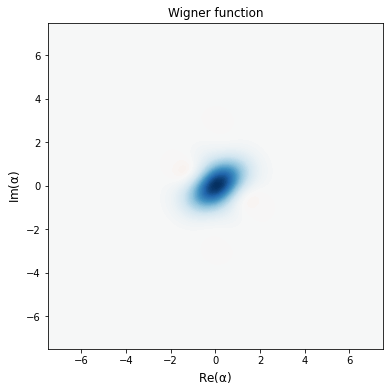

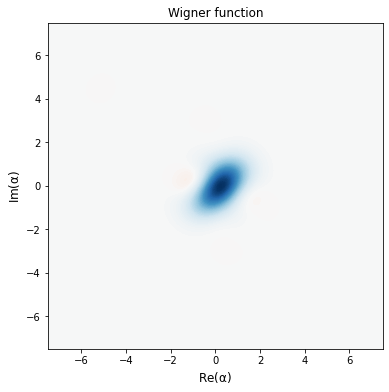

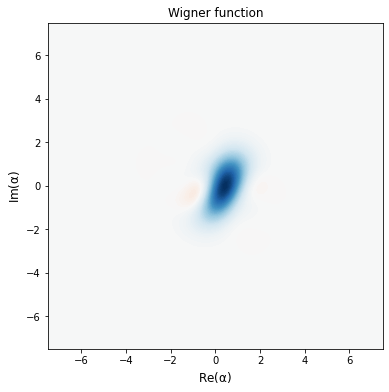

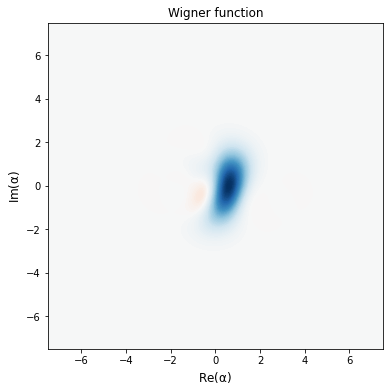

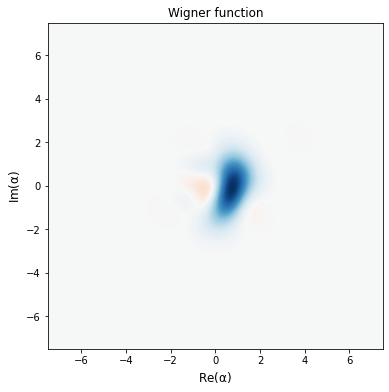

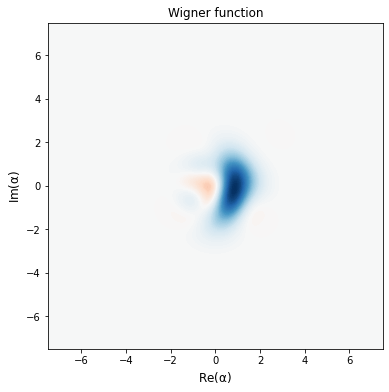

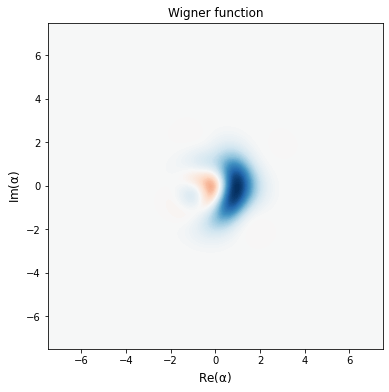

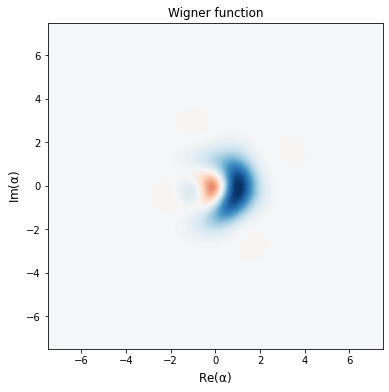

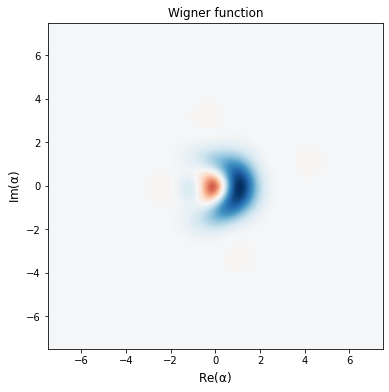

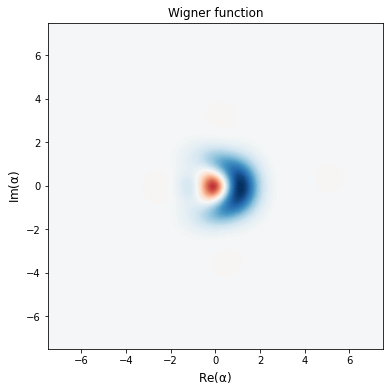

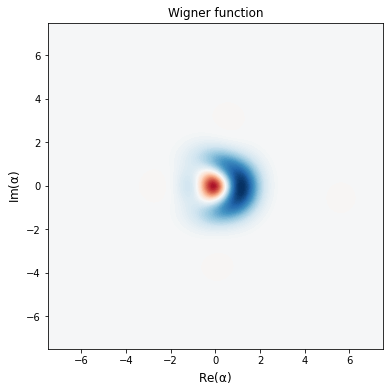

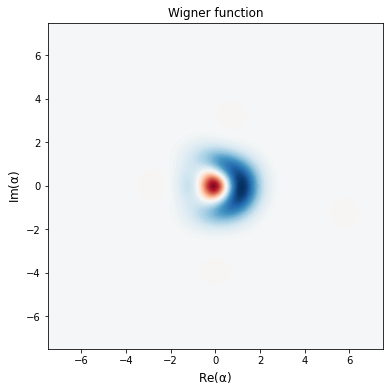

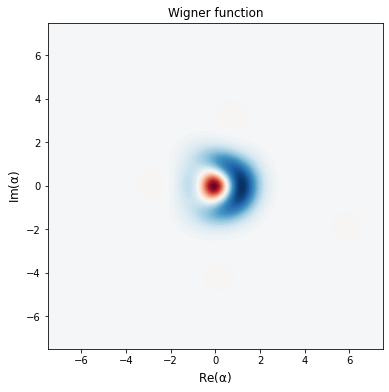

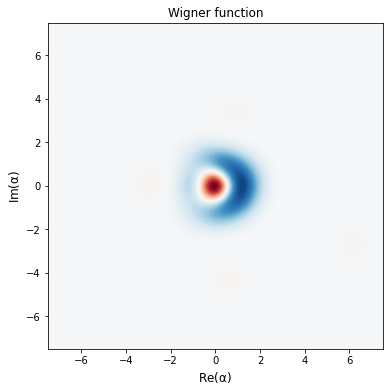

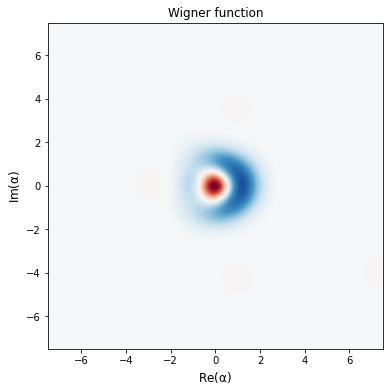

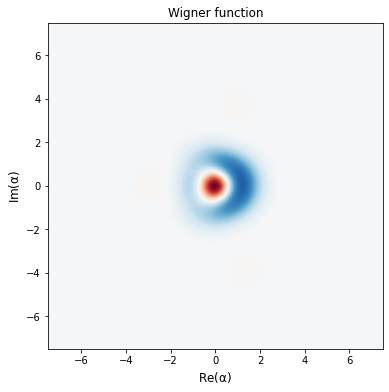

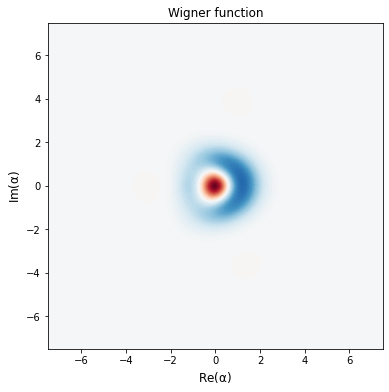

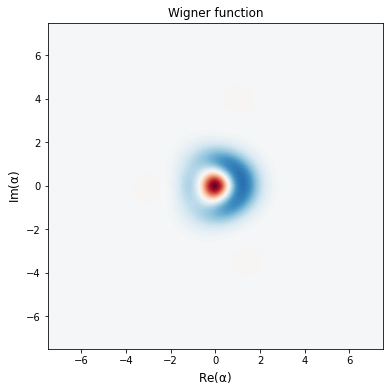

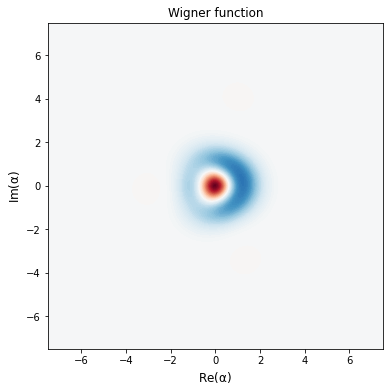

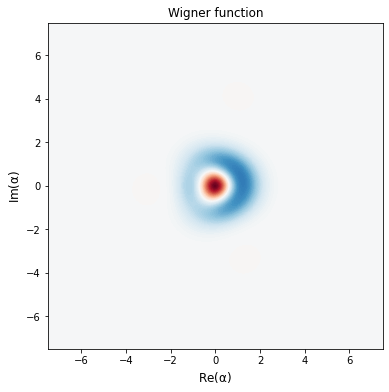

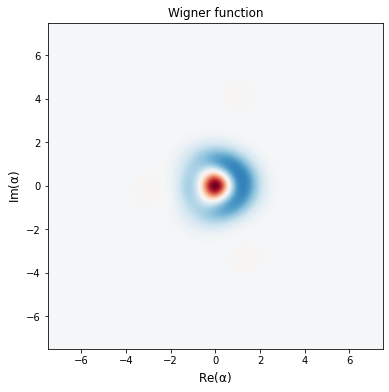

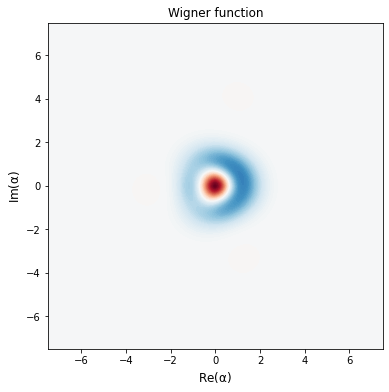

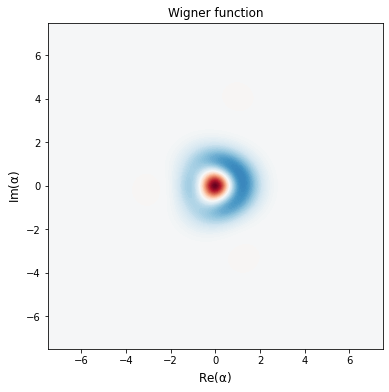

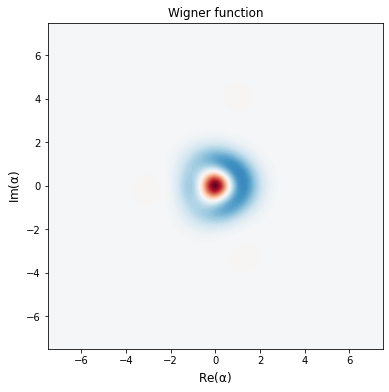

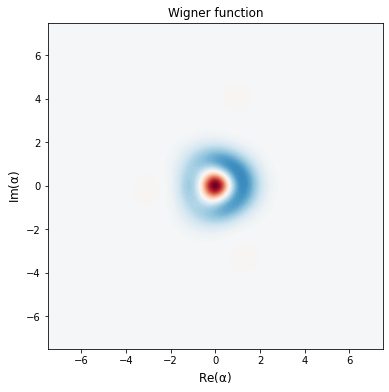

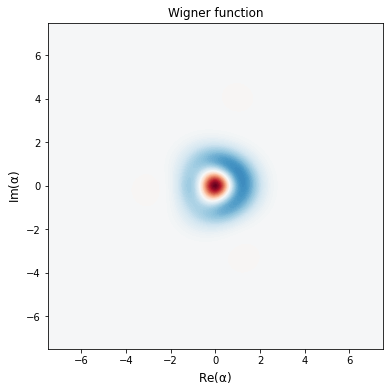

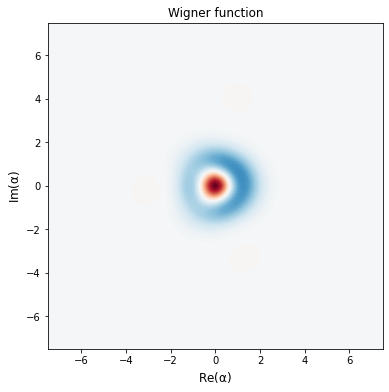

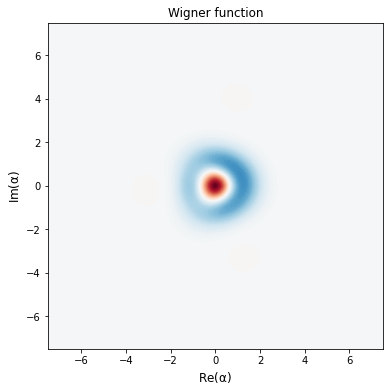

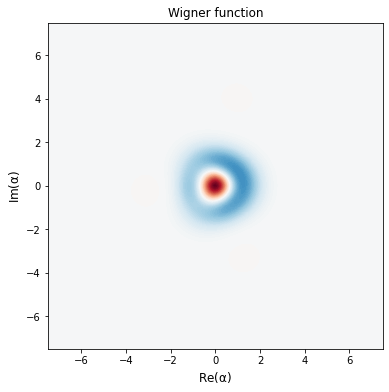

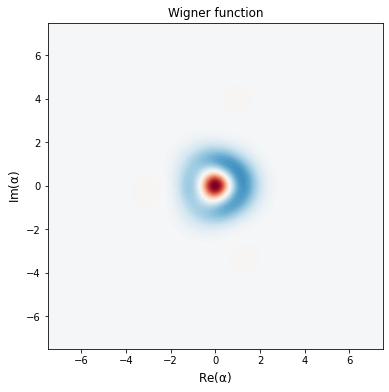

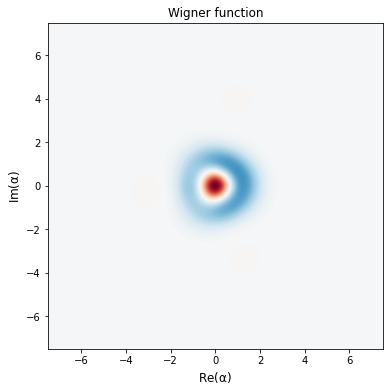

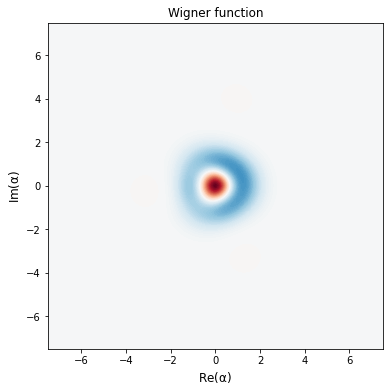

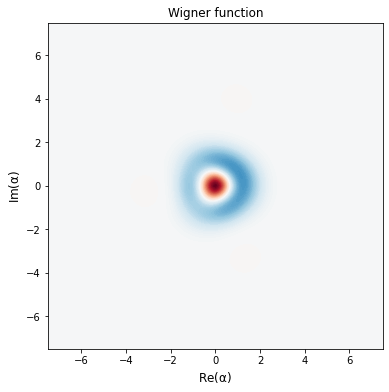

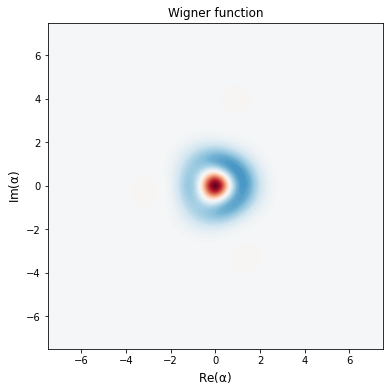

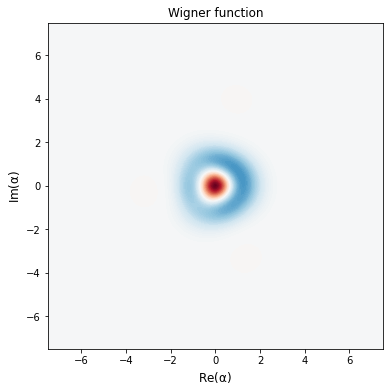

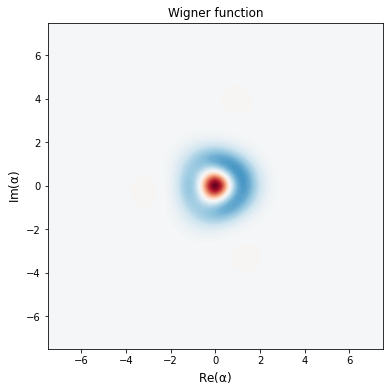

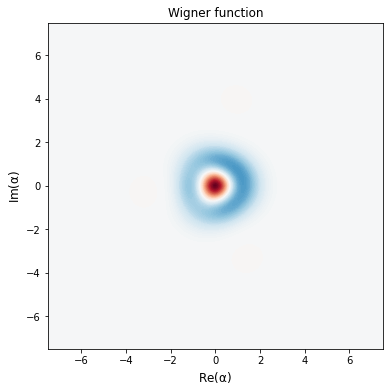

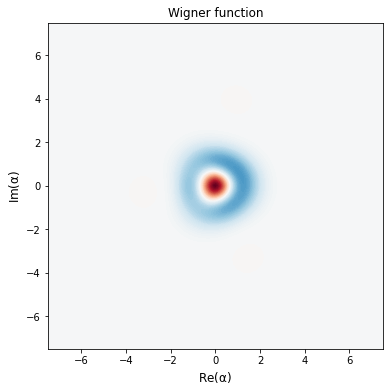

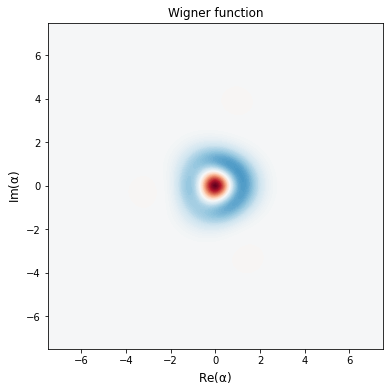

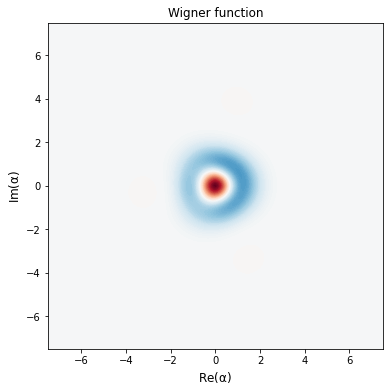

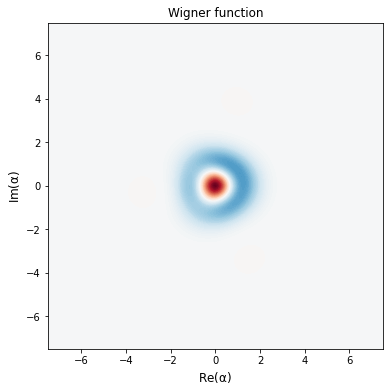

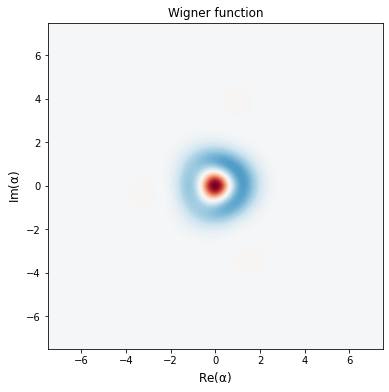

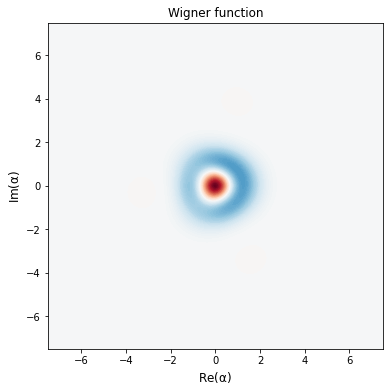

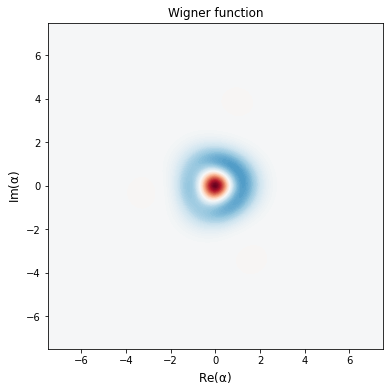

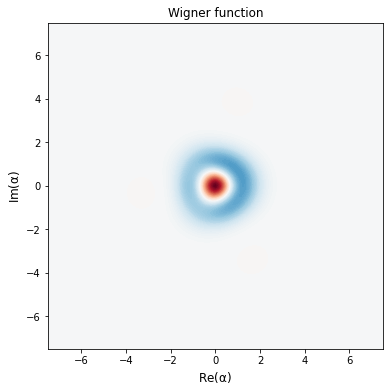

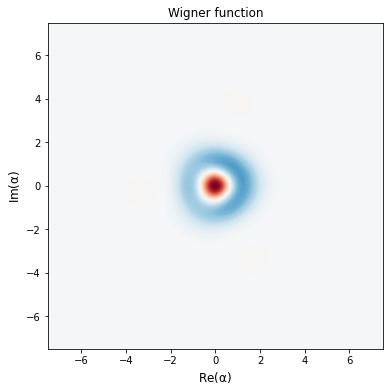

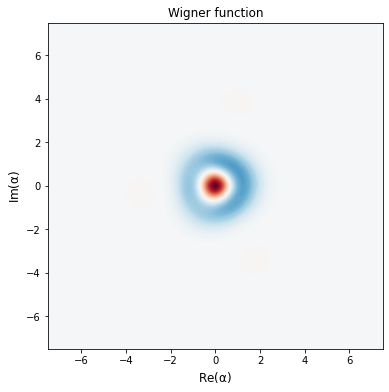

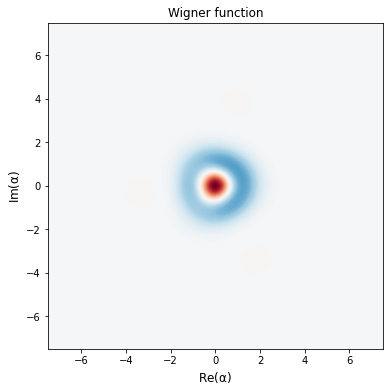

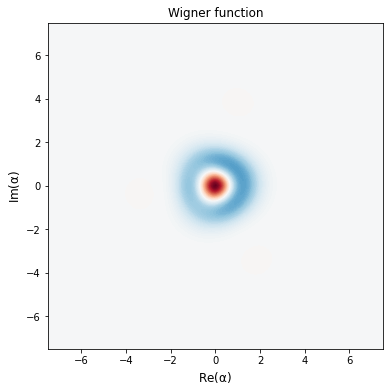

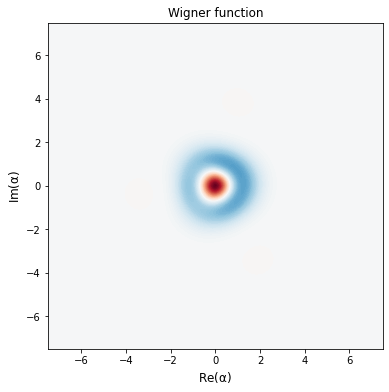

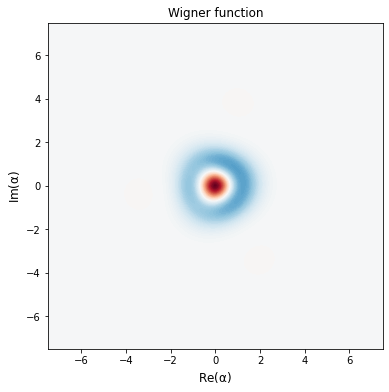

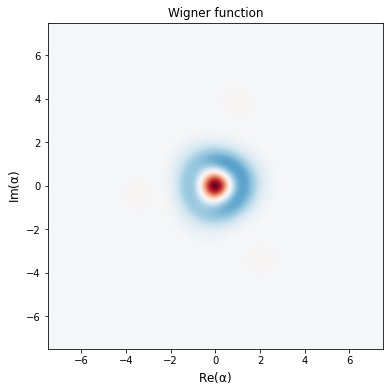

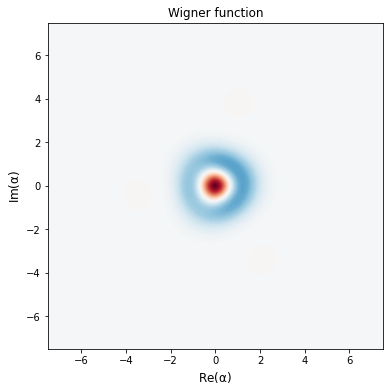

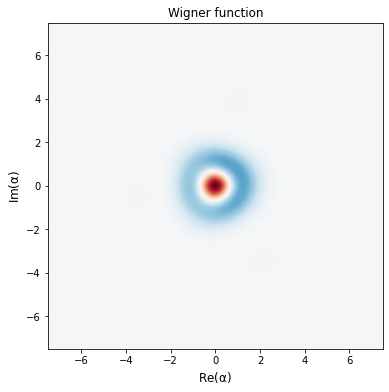

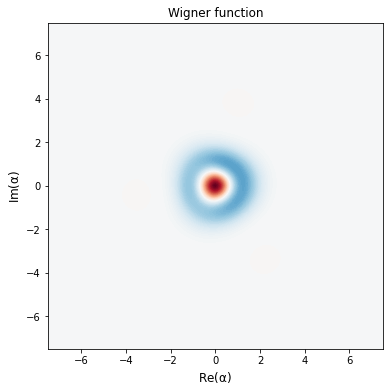

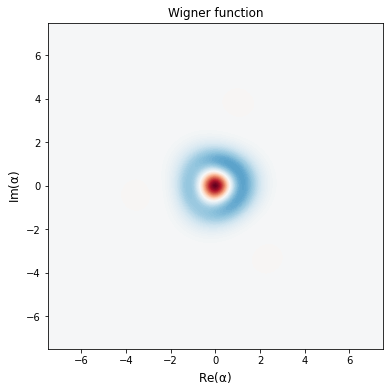

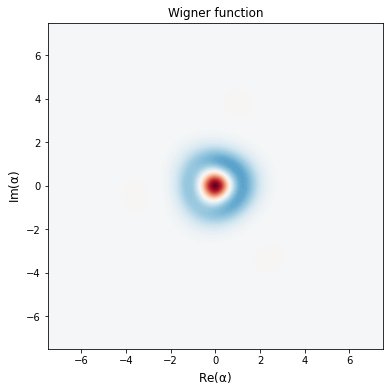

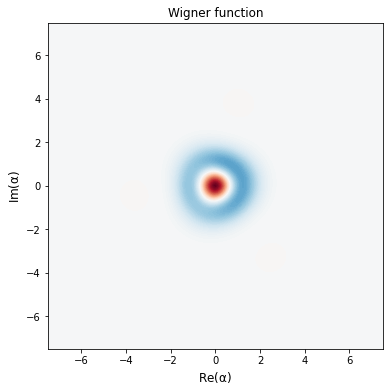

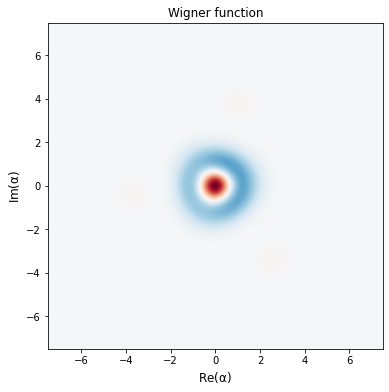

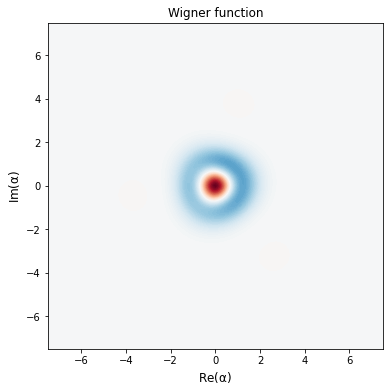

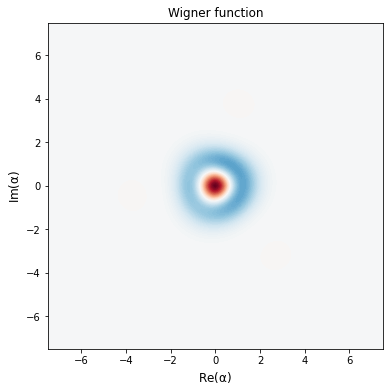

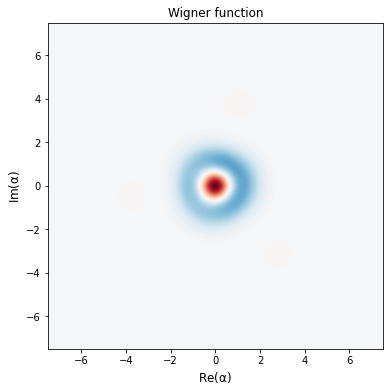

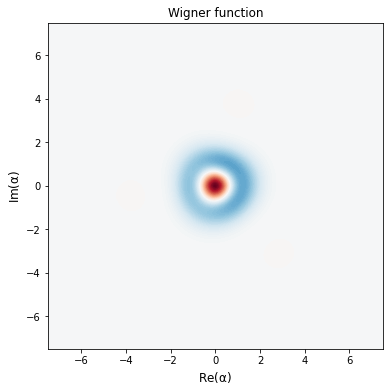

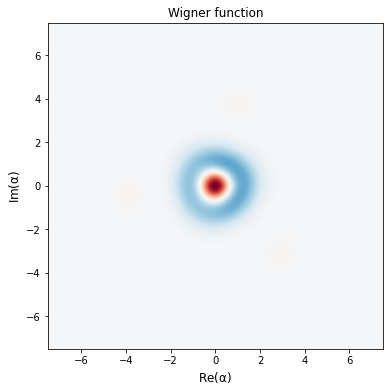

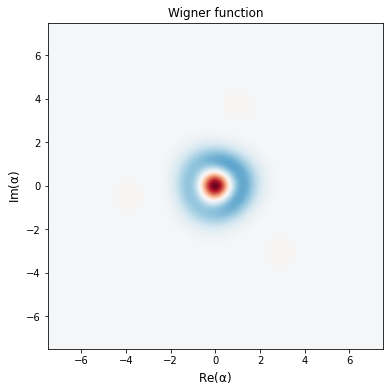

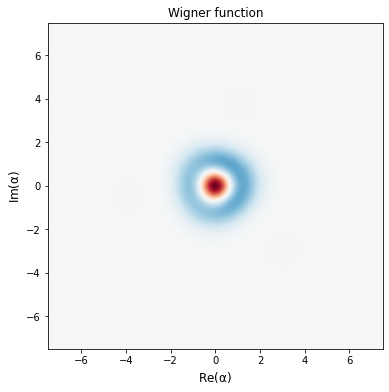

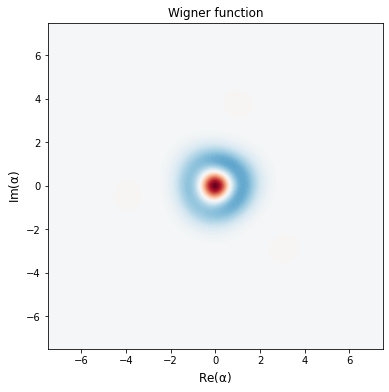

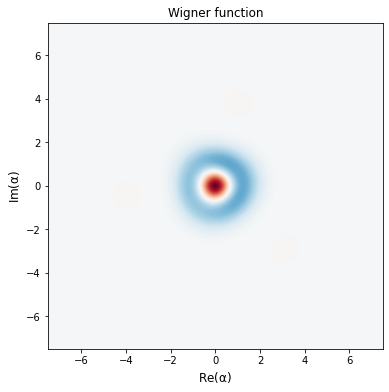

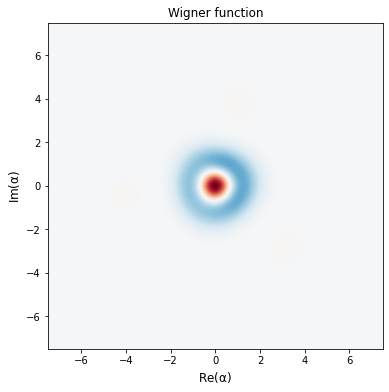

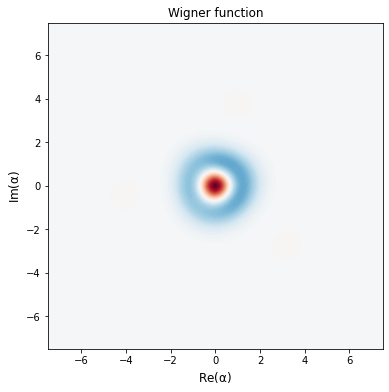

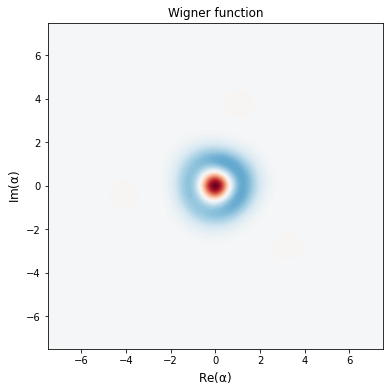

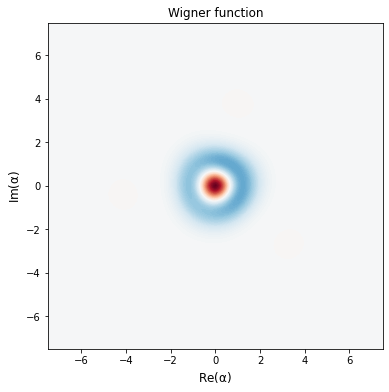

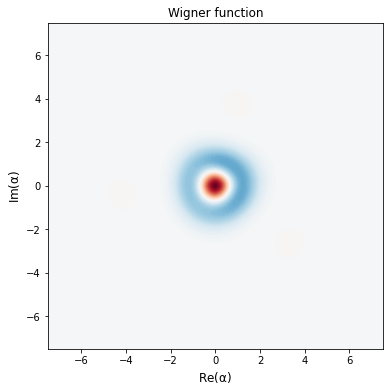

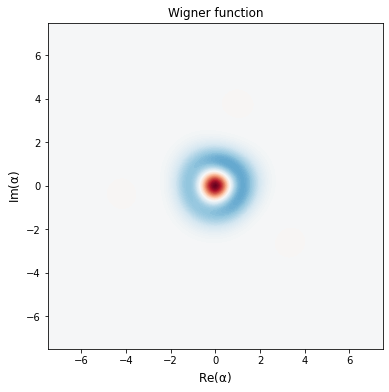

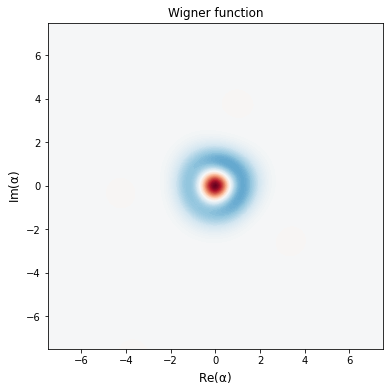

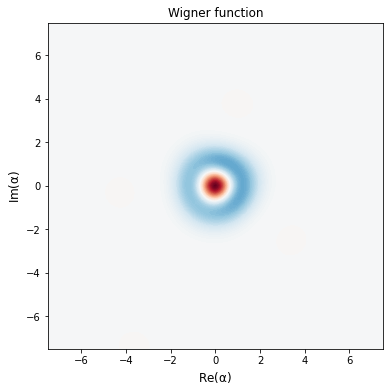

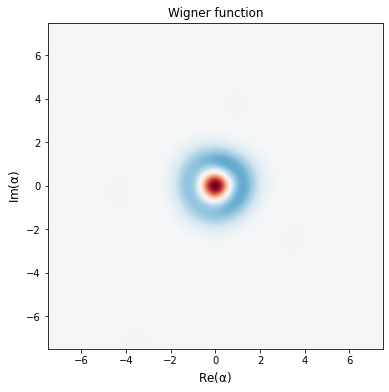

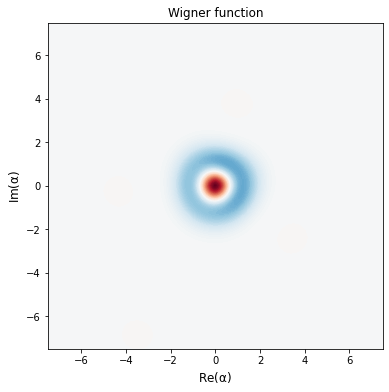

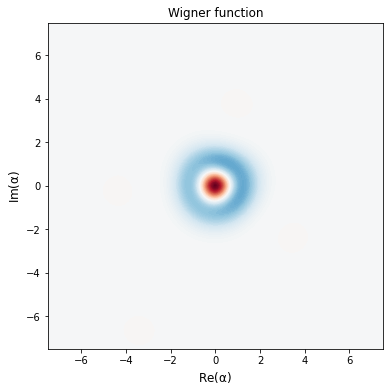

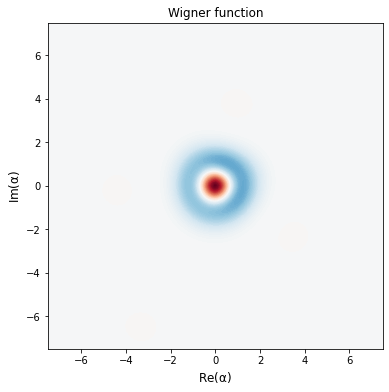

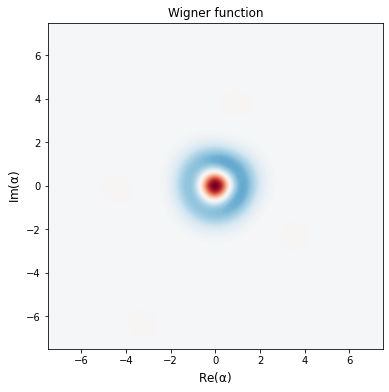

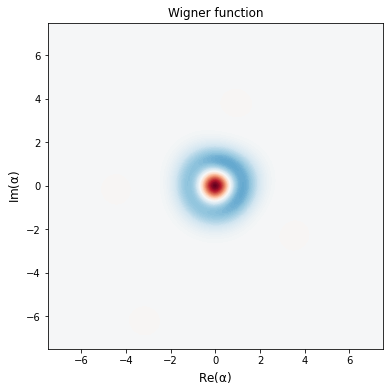

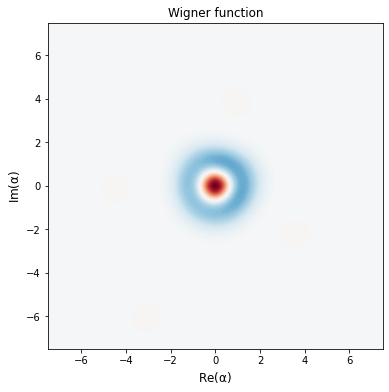

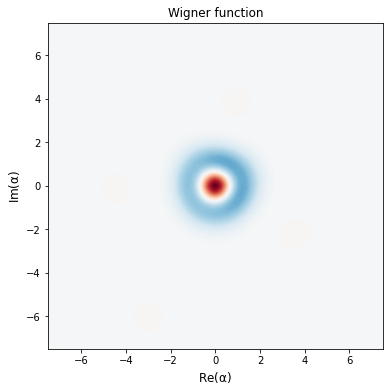

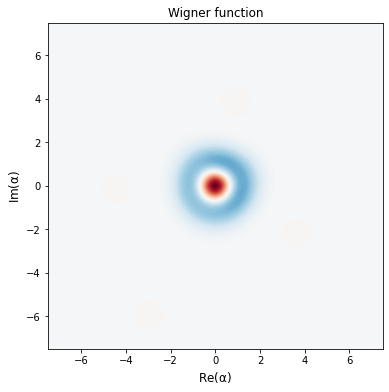

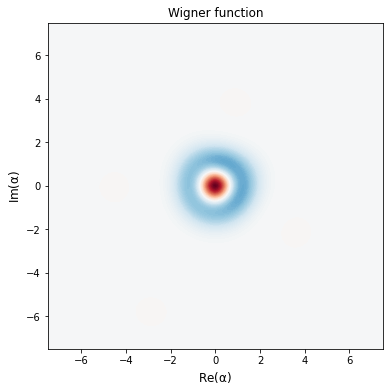

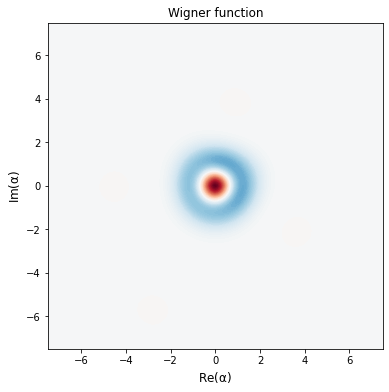

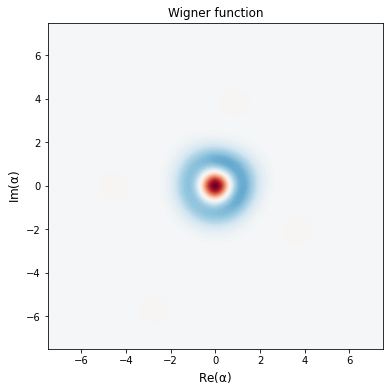

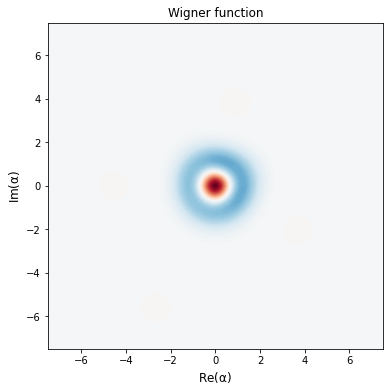

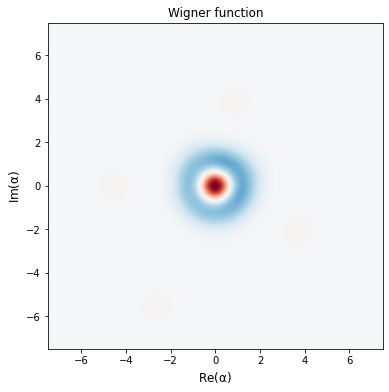

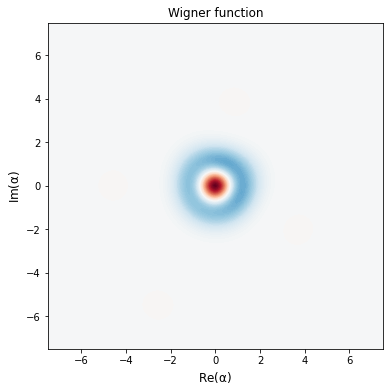

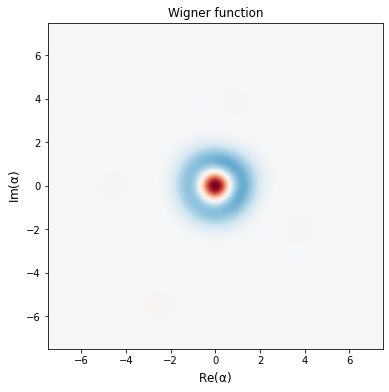

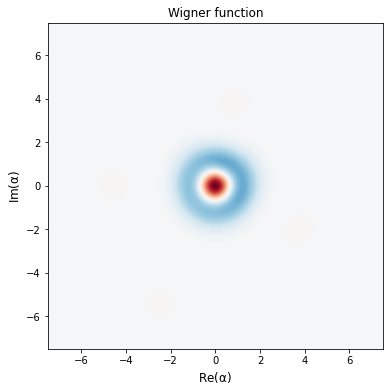

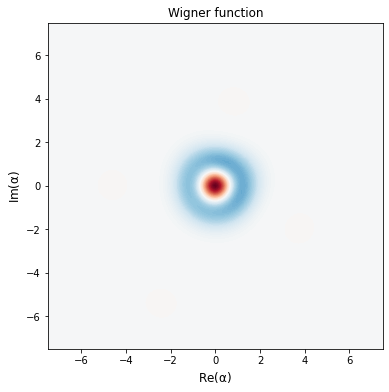

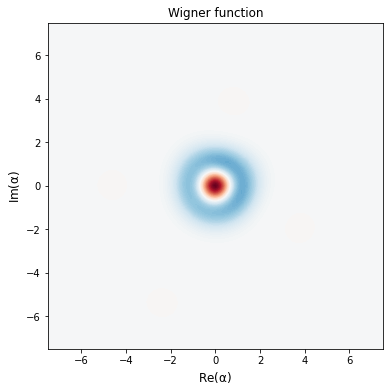

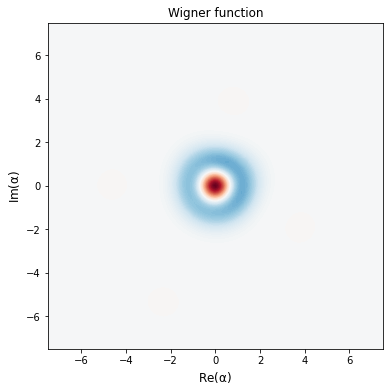

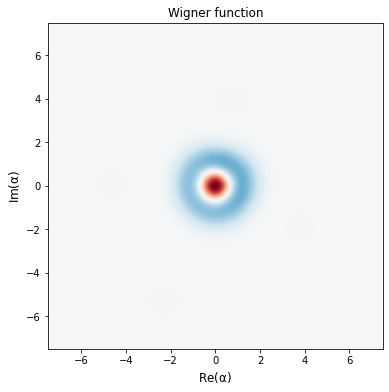

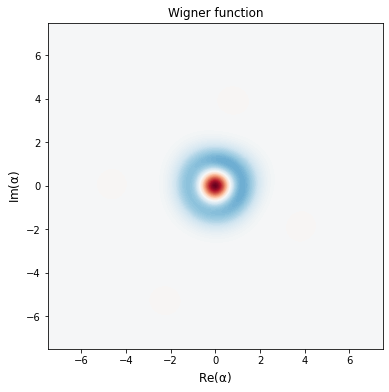

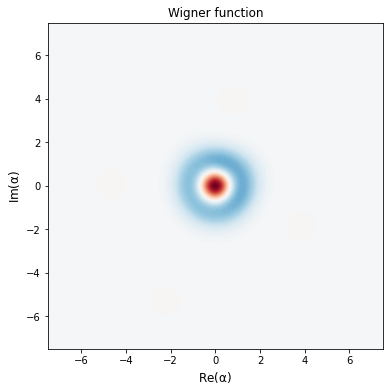

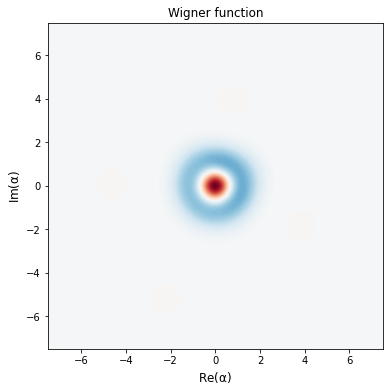

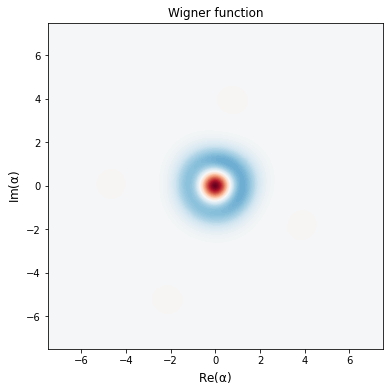

In [34]:
for i in range(len(state_history)):
    plot_wigner(Qobj(state_history[i]))

In [35]:
# save data
cost_history_np = np.array(cost_history)
params_history_np = np.array(params_history)
library = 'strawberry fields'
optname = '_adam'
statename = '_gkp0.1'
cpuname = 'intel_core_i7_11gen'
savename = library+'_d'+str(depth)+'_step'+str(steps)+optname+'_rate'+str(rate)+'_eps0.001_'
np.save(savename+'cost'+statename, cost_history_np)
np.save(savename+'params'+statename, params_history_np)
fid = (1-cost_history_np.min())**2
amin = cost_history_np.argmin()
f = open(savename+'.txt', 'a')
f.write('\n')
if steps > 1000:
    datalist = ['CPU: '+cpuname+'\n', savename+statename+'\n', 'Cutoff dimention: '+str(dim)+'\n',
                'Runtime: '+str(end-start)+'s\n', 'Fidelity: '+str(fid)+'\n', 'argmin: '+str(amin)+'\n',
                'Fidelity1000: '+str((1-cost_history_np[1000])**2)+'\n']
else:
    datalist = ['CPU: '+cpuname+'\n', savename+statename+'\n', 'Cutoff dimention: '+str(dim)+'\n', 
                'Runtime: '+str(end-start)+'s\n', 'Fidelity: '+str(fid)+'\n', 'argmin: '+str(amin)+'\n']
f.writelines(datalist)
f.close()
print(amin, fid)
print(savename)

1000 0.9856189128742721
strawberry fields_d8_step1000_adam_rate0.001_eps0.001_


4000 0.9935959974036861


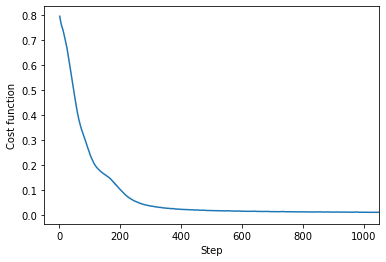

In [46]:
co = np.load('d8_step4000_adam_rate0.001_eps0.001_cost_d_cat.npy')
print(co.argmin(), (1-co[3999])**2)
plt.plot(np.linspace(1, len(co), len(co)), co)
plt.xlim([-50,1050])
plt.xlabel('Step')
plt.ylabel('Cost function')
plt.show()

5001


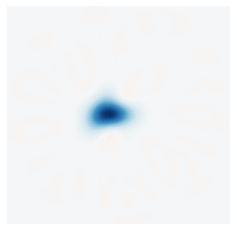

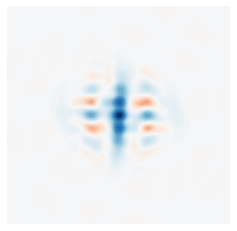

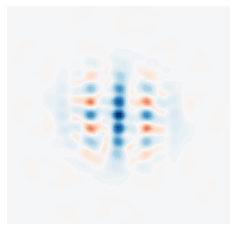

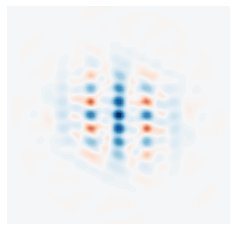

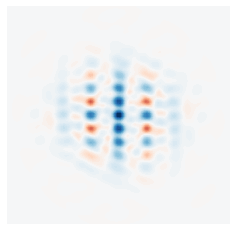

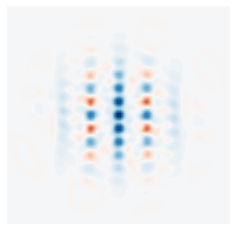

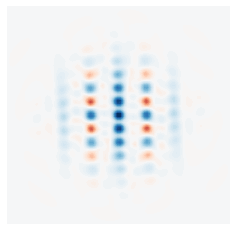

In [72]:
depth = 10
dim = 30
par = np.load('d10_step5000_adam_rate0.001_eps0.001_params_gkp0.1.npy')
print(len(par))
plot_list = [0, 70, 120, 200, 350, 1000, 3999]

for i in plot_list:
    sta = variational_quantum_circuit(par[i])
    plot_wigner(sta)